In [1]:
import torch 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt; plt.rcParams["figure.dpi"] = 500
import numpy as np
import h5py
import sys 
models_folder = "...\\vae-project\\Models architecture"
sys.path.append(models_folder)

In [2]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

## Importing the model and loading the trained weights

In [3]:
weights_path =  '...\\z32_beta0.1_weightscvae2.pt'
weights, hyperparameters = torch.load(weights_path)


z_dim = hyperparameters["z_dim"]
batchsize = hyperparameters["batch size"]


In [4]:
# Try to change the model for cvae or fancy_cvae (need to have nc = 2 then)
from cvae2 import VariationalAutoencoder
nc, nf =1, 64
vae = VariationalAutoencoder(nc, nf, z_dim).to(device)

## Importing data 

In [5]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, file):
        self.file = file
        self.hdf = h5py.File(file, 'r')
        self.datasets = list(self.hdf.keys())

    def __len__(self):
        return len(self.hdf[self.datasets[0]])
    
    def __getitem__(self,idx):
        
        x = self.hdf[self.datasets[0]][idx]
        z = self.hdf[self.datasets[1]][idx]

        return x, z

In [6]:
data_cosmic_survey = '...\\cosmos_25.2_all_with_zphot.h5'
galaxy_dataset = dataset(data_cosmic_survey)

In [7]:
# Changes needed in the loop for the cvae and fancy_cvae models 
mu = torch.empty(size = (len(galaxy_dataset), z_dim))

for i, x in enumerate(galaxy_dataset):
     galaxy_image = torch.from_numpy(x[0]).unsqueeze(0).to(device)
     condition = torch.tensor([x[1]]).to(device)
     z = vae.encoder(galaxy_image, condition)
     mu[i] = vae.encoder.mu.detach()


In [8]:
for i in range(z_dim): 
    var = "mu" + f"{i}"
    locals()[var] = mu[:,i]

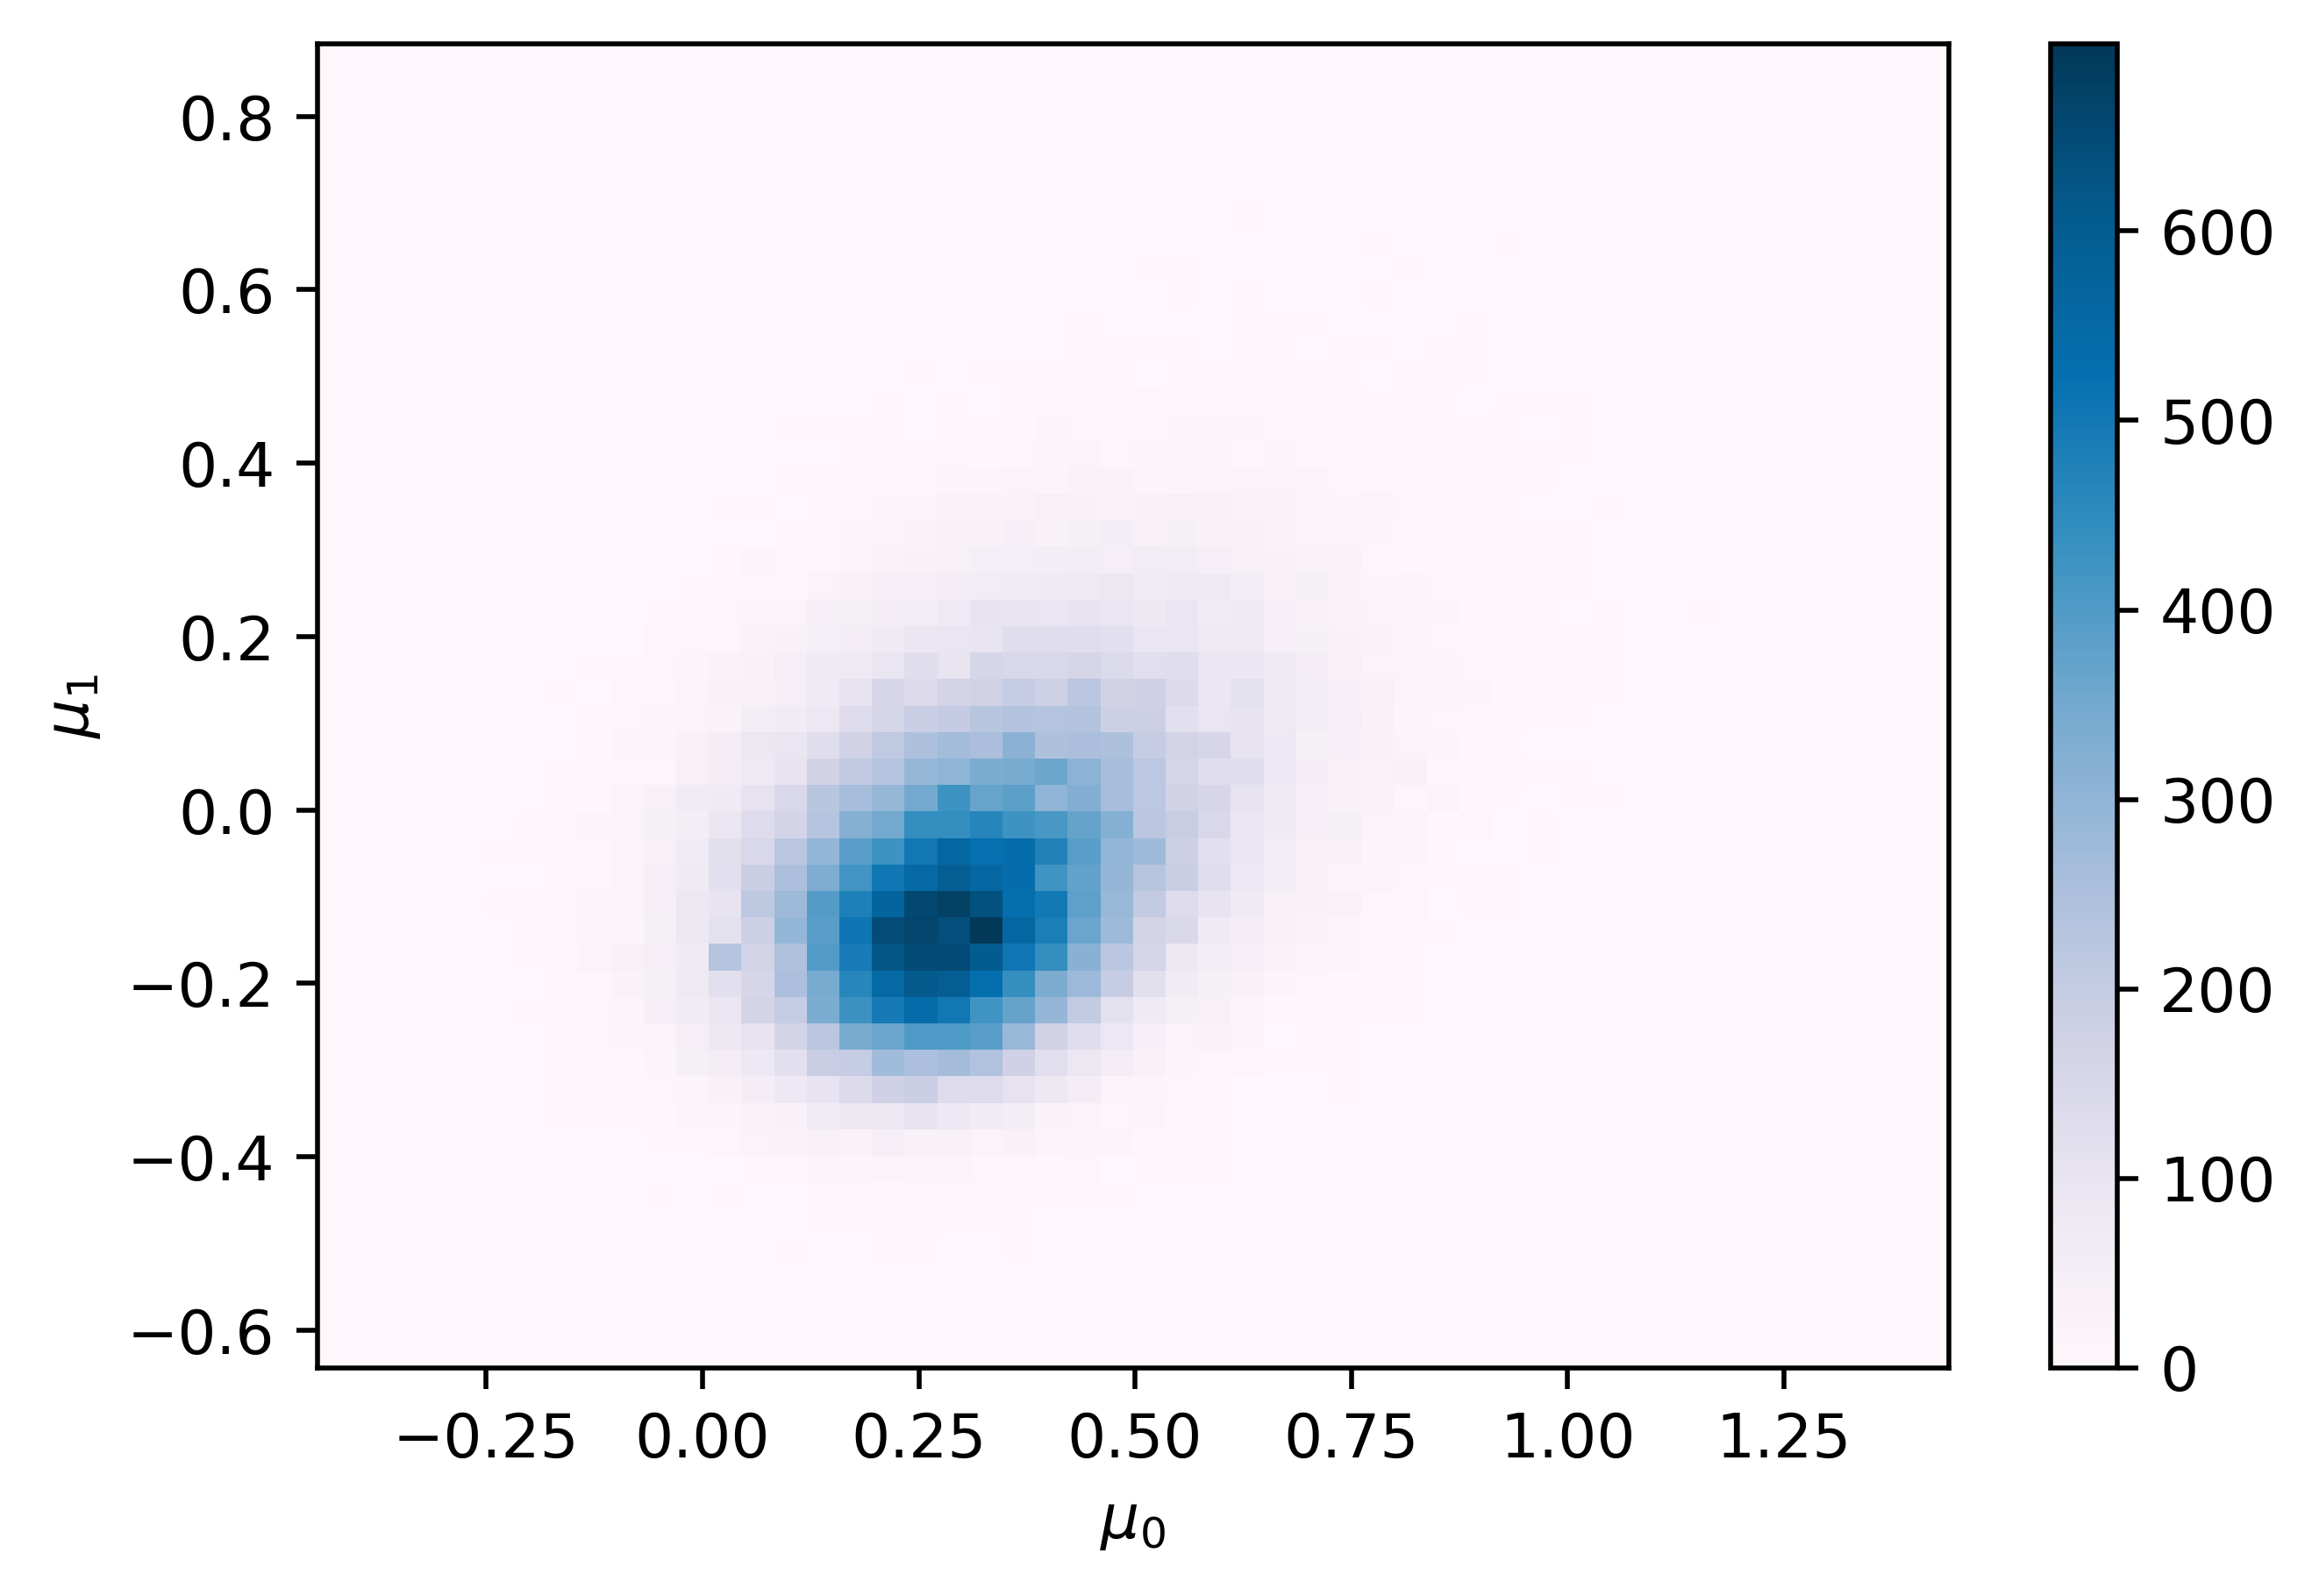

In [9]:
plt.hist2d(mu0.numpy(), mu1.numpy(), bins = 50, cmap = 'PuBu')
plt.xlabel(r"$\mu_0$")
plt.ylabel(r"$\mu_1$")
plt.colorbar()
